In [4]:
import os
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt


import sys
sys.path.append('../scripts/')
import utils
import plot
from vae_model import CVAE

## 1. Load in Data

In [5]:
#Load the date from 2021
train_series, train_attr, val_series, val_attr, test_series, test_attr = utils.get_data('2021')

#Standardize the data
train_series, val_series, _, scaler_data = utils.standardize_data(train_series, val_series, test_series)

#perform one-hot encoding
ONEHOTENCODE = ['is_weekend','season','PV']
train_attr = utils.one_hot_encode_columns(train_attr, ONEHOTENCODE)
val_attr = utils.one_hot_encode_columns(val_attr, ONEHOTENCODE)
test_attr = utils.one_hot_encode_columns(test_attr, ONEHOTENCODE)

# MinMax scale the attributes -> this keeps the scales, which might be important for some attributes!
train_attr, val_attr, test_attr, scaler_attr = utils.minmax_scale_attributes(train_attr,val_attr,test_attr)

#Create dataloaders for pytorch
train_dataset = TensorDataset(torch.tensor(train_series, dtype=torch.float32), torch.tensor(train_attr, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_series, dtype=torch.float32), torch.tensor(val_attr, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=1028, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1028, shuffle=False)

test_attr  = torch.tensor(test_attr, dtype=torch.float32)

## 2. Define parameters & Initialize model

In [8]:
input_size = train_series.shape[1] 
condition_size = train_attr.shape[1]
latent_size = 40

RUN = 8
TITLE = 'LS_40_Dec_FCN'
RUN_OUTPUT_DIR = 'runs' + '/' + 'run'+str(RUN) + '/' + TITLE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
cvae_FCN = CVAE(input_size, latent_size, condition_size, device,'FCN').to(device)
cvae_FCN.train_model(train_loader, 
                     val_loader, 
                     epochs = 800, 
                     output_dir = RUN_OUTPUT_DIR,
                     device = device,
                     lr = 0.001,
                     patience=200)

Epoch 10/800, Loss: 38.70862048605214, Validation Loss: 39.76827163696289
Epoch 20/800, Loss: 33.06197440105936, Validation Loss: 34.612290954589845
Epoch 30/800, Loss: 31.686853077100672, Validation Loss: 32.87790794372559
Epoch 40/800, Loss: 30.515538588814113, Validation Loss: 31.640623092651367
Epoch 50/800, Loss: 29.279466463171918, Validation Loss: 30.868368911743165
Epoch 60/800, Loss: 29.0658947488536, Validation Loss: 30.39681930541992
Epoch 70/800, Loss: 28.75878441852072, Validation Loss: 30.200298309326172
Epoch 80/800, Loss: 28.006737418796707, Validation Loss: 29.783634185791016
Epoch 90/800, Loss: 27.888520282247793, Validation Loss: 30.002952575683594
Epoch 100/800, Loss: 27.573115556136422, Validation Loss: 29.673674392700196
Epoch 110/800, Loss: 28.519804000854492, Validation Loss: 29.99050407409668
Epoch 120/800, Loss: 27.242642444113027, Validation Loss: 29.308893966674805
Epoch 130/800, Loss: 26.886546425197434, Validation Loss: 29.15509796142578
Epoch 140/800, Los

In [5]:
TITLE = 'LS_40_add_attr__CNN'
RUN_OUTPUT_DIR = 'runs' + '/' + 'run'+str(RUN) + '/' + TITLE
cvae_CNN = CVAE(input_size, latent_size, condition_size, device, 'CNN').to(device)
cvae_CNN.train_model(train_loader, 
                     val_loader, 
                     epochs = 1000, 
                     output_dir = RUN_OUTPUT_DIR,
                     device = device,
                     lr = 0.001,
                     patience=300)

Epoch 10/1000, Loss: 40.66477054098378, Validation Loss: 42.28407287597656
Epoch 20/1000, Loss: 35.15770190695058, Validation Loss: 40.30379867553711
Epoch 30/1000, Loss: 32.6608537591022, Validation Loss: 38.060237121582034
Epoch 40/1000, Loss: 31.242825217868972, Validation Loss: 34.776737213134766
Epoch 50/1000, Loss: 31.670786899069082, Validation Loss: 37.96930770874023
Epoch 60/1000, Loss: 29.399489941804305, Validation Loss: 32.179389572143556
Epoch 70/1000, Loss: 28.487386288850203, Validation Loss: 31.94165802001953
Epoch 80/1000, Loss: 27.951336570408035, Validation Loss: 31.687820434570312
Epoch 90/1000, Loss: 27.477626883465312, Validation Loss: 30.4457763671875
Epoch 100/1000, Loss: 26.749205133189324, Validation Loss: 30.092869567871094
Epoch 110/1000, Loss: 26.056569887244184, Validation Loss: 29.530812072753907
Epoch 120/1000, Loss: 26.45519380984099, Validation Loss: 29.665534210205077
Epoch 130/1000, Loss: 26.868890513544496, Validation Loss: 33.8626205444336
Epoch 14

## 3. Generate Data
Generate for each attribute in the test set, 1 sample

In [23]:
#Load the best models
cvae_FCN.load_state_dict(torch.load(r'C:\Thesis\vae\runs\run7\LS_40_add_attr_FCN\best_model.pt'))
cvae_FCN.eval()
cvae_CNN.load_state_dict(torch.load(r'C:\Thesis\vae\runs\run7\LS_40_add_attr__CNN\best_model.pt'))
cvae_CNN.eval()

CVAE(
  (encoder): EncoderCNN(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=6166, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=40, bias=True)
    (fc_var): Linear(in_features=256, out_features=40, bias=True)
  )
  (decoder): DecoderCNN(
    (fc1): Linear(in_features=62, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=12288, bias=True)
    (deconv1): ConvTranspose1d(128,

In [24]:
generated_fcn = []
generated_cnn = []
for i, (org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = cvae_FCN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated_fcn.extend(new_samples)

        new_samples = cvae_CNN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated_cnn.extend(new_samples)

generated_fcn = np.array(generated_fcn)
generated_cnn = np.array(generated_cnn)

100%|██████████| 4857/4857 [00:06<00:00, 797.56it/s]


## 4. Model evaluation

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics_model(model, test_series, test_attr, scaler_data):
    energy_score = []
    mse = []
    mae = []
    
    for i,(org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = model.generate_samples(250,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)

        energy_score.append(utils.calculate_energy_score([1/250]*250, new_samples, org_serie))
        mse.append(mean_squared_error(new_samples,np.array([org_serie]*250)))
        mae.append(mean_absolute_error(new_samples,np.array([org_serie]*250)))

    print('Energy Score:', np.mean(energy_score))
    print('mse', np.mean(mse))
    print('mae', np.mean(mae))

### 4.1 Energy Score

For each attribute generate 250 samples & compare with the ground truth.

In [43]:
print('FCN')
calculate_metrics_model(cvae_FCN,test_series,test_attr,scaler_data)

FCN


100%|██████████| 4857/4857 [00:12<00:00, 386.16it/s]

Energy Score: 0.9174298458733671
mse 0.031679739947001746
mae 0.09827193631746875


In [27]:
print('CNN')
calculate_metrics_model(cvae_CNN,test_series,test_attr,scaler_data)

CNN


100%|██████████| 4857/4857 [00:13<00:00, 348.28it/s]

Energy Score: 0.9281587040539253
mse 0.03257160145827778
mae 0.10255730240046133


Calculate for random days & random

In [13]:
es_random = []
es_similar_days = []
mse_similar_days = []
mse_random = []
mae_similar_days = []
mae_random = []
for (org_serie,attr) in tqdm(zip(test_series.values,test_attr),total=len(test_attr)):
    samples_random = utils.get_random_days(test_series.values,250)
    samples_similar = utils.get_similar_days(test_series.values,test_attr,attr,250)
    es_random.append(utils.calculate_energy_score([1/250]*250, samples_random, org_serie))
    es_similar_days.append(utils.calculate_energy_score([1/250]*250, samples_similar, org_serie))
    mse_similar_days.append(mean_squared_error(samples_similar,np.array([org_serie]*250)))
    mse_random.append(mean_absolute_error(samples_random,np.array([org_serie]*250)))
    mae_similar_days.append(mean_squared_error(samples_similar,np.array([org_serie]*250)))
    mae_random.append(mean_absolute_error(samples_random,np.array([org_serie]*250)))

print('SIMILAR-es:' ,np.mean(es_similar_days))
print('RANDOM-es:' ,np.mean(es_random))
print('SIMILAR-mse:' ,np.mean(mse_similar_days))
print('RANDOM-mse:' ,np.mean(mse_random))
print('SIMILAR-mae:' ,np.mean(mae_similar_days))
print('RANDOM-mae:' ,np.mean(mae_random))

100%|██████████| 4857/4857 [00:11<00:00, 428.05it/s]

SIMILAR-es: 1.0893003571199036
RANDOM-es: 1.3458966940813002
SIMILAR-mse: 0.06385754949686595
RANDOM-mse: 0.1889729475096081
SIMILAR-mae: 0.06385754949686595
RANDOM-mae: 0.1889729475096081


### 3.2 Visualization techniques

#### 3.2.1 Load Curves

In [28]:
def calculate_mean_loadcurve(data):
    load_curves = []
    for d in data:
        shift = np.abs(np.min(d)) + 1e-6
        ts_shifted = d + shift
        ts_sorted = np.sort(ts_shifted)
        # Compute the cumulative probability of occurrence for each data point
        # cdf = np.cumsum(ts_sorted) / np.sum(ts_sorted)
        load_curves.append(ts_sorted)
    return np.mean(load_curves,axis=0)

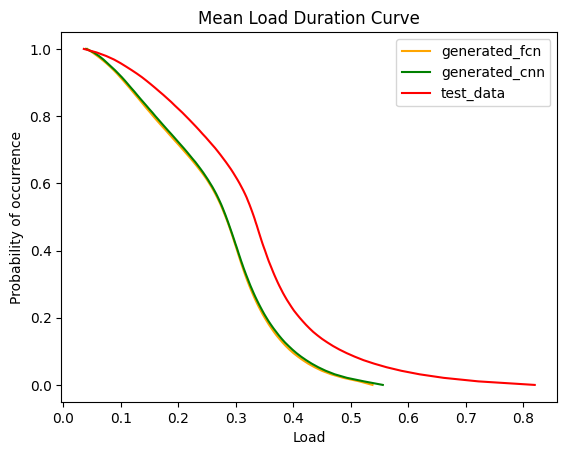

In [29]:
fig, ax = plt.subplots()

ax.plot(calculate_mean_loadcurve(generated_fcn),np.linspace(1, 0, len(calculate_mean_loadcurve(generated_fcn))), c='orange',label='generated_fcn')
ax.plot(calculate_mean_loadcurve(generated_cnn),np.linspace(1, 0, len(calculate_mean_loadcurve(generated_cnn))), c='green',label='generated_cnn')
ax.plot(calculate_mean_loadcurve(test_series.values),np.linspace(1, 0, len(calculate_mean_loadcurve(test_series.values))), c='r',label='test_data')

# Plot the load duration curve
ax.set_xlabel('Load')
ax.set_ylabel('Probability of occurrence')
ax.set_title('Mean Load Duration Curve')
ax.legend()
plt.show()

#kernel density estimation

#### 3.2.2 Quantile Plots

In [30]:
def create_quantile_plot(time_series,single_time_series=None):
    quantiles = np.arange(0.0,1.05,0.05)
    time_series_quantiles = np.quantile(time_series,quantiles,axis=0)
    timestamps = np.arange(time_series_quantiles.shape[1])
    cmap = plt.get_cmap('Blues', len(quantiles)//1.5)
    for i in range(len(quantiles)-1):
        color_idx = i if i < len(quantiles) // 2 else len(quantiles) - 2 - i
        plt.fill_between(timestamps, time_series_quantiles[i], time_series_quantiles[i + 1],
                     color=cmap(color_idx + 1), alpha=1)

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Time Series Quantiles (0-100)')
    if single_time_series is not None:
        plt.plot(single_time_series,c='orange')
    plt.show()

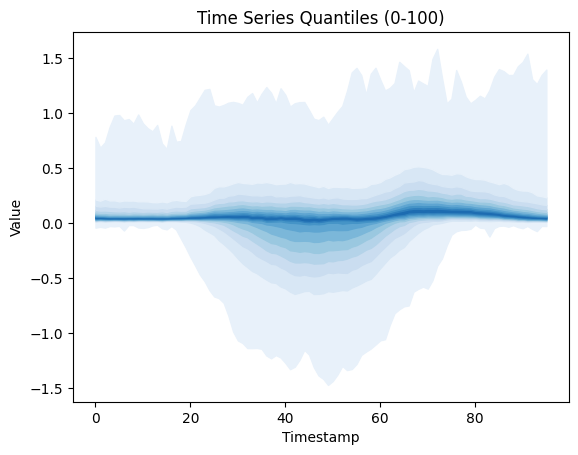

In [31]:
create_quantile_plot(generated_fcn)

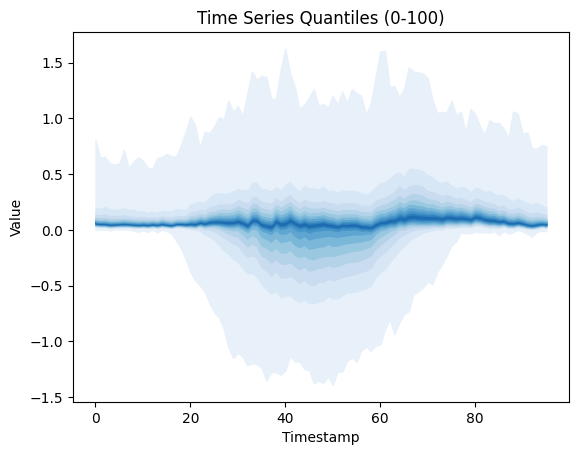

In [32]:
create_quantile_plot(generated_cnn)

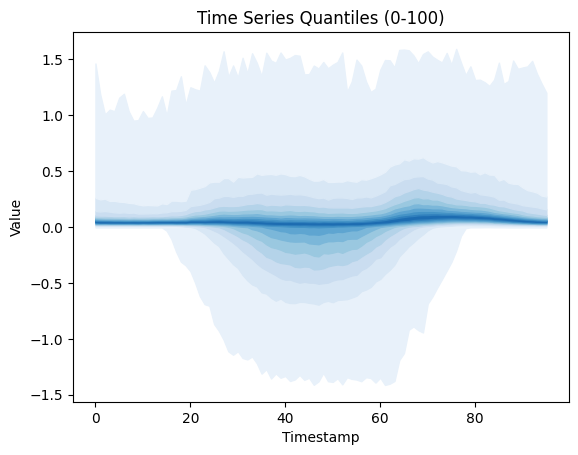

In [33]:
create_quantile_plot(test_series)

### 3.3 Classifier
Create a classifier that trains a model to classify real from fake

In [35]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

generated_data = generated_cnn
combined_data = np.vstack((test_series, generated_data))

# Create labels: 0 for real, 1 for fake
labels = np.zeros((test_series.shape[0] + generated_data.shape[0],))
labels[test_series.shape[0]:] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.3, random_state=42)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Train an SVM classifier
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

c:\Users\jankr\miniconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8500857632933104
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      1474
         1.0       0.80      0.93      0.86      1441

    accuracy                           0.85      2915
   macro avg       0.86      0.85      0.85      2915
weighted avg       0.86      0.85      0.85      2915

Accuracy: 0.907032590051458
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1474
         1.0       0.88      0.95      0.91      1441

    accuracy                           0.91      2915
   macro avg       0.91      0.91      0.91      2915
weighted avg       0.91      0.91      0.91      2915

